# **PROJET ACCIDENTOLOGIE VEHICULES : KAGGLE ESIEE 2023 - 2024**

# **OUVERTURE DES FICHIERS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def open_file(item):
    # Création d'un DataFrame vide pour accumuler les données
    all_data = pd.DataFrame()

    # Boucle sur chaque année
    for annee in range(2012, 2023):
        path = f"TRAIN/BAAC-Annee-{annee}/{item}_{annee}_.csv"
        try:
            # Lecture du fichier CSV
            file = pd.read_csv(path, delimiter=';', index_col = 0,low_memory=False)
            # Concaténation du fichier lu avec le DataFrame global
            all_data = pd.concat([all_data, file])
        except FileNotFoundError:
            print(f"Le fichier {path} n'a pas été trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {path}: {e}")

    return all_data

In [4]:
def create_dataframe():

    caracteristiques = open_file('caracteristiques')
    lieux = open_file('lieux')
    usagers = open_file('usagers')
    vehicules = open_file('vehicules')

    return caracteristiques,lieux,usagers,vehicules

In [5]:
caracteristiques,lieux,usagers,vehicules = create_dataframe()

### **Isolation de la colonne Grave**

In [6]:
# Convertir la colonne 'grav' en array numpy
grav_array = usagers['grav'].values
num_acc_array = usagers['Num_Acc'].values

# Créer un array pour la présence de 'GRAVE'
is_grave = np.isin(grav_array, [2, 3])

# Utiliser ufuncs de numpy pour créer un mapping de 'Num_Acc' à 'GRAVE'
unique_nums, grave_presence = np.unique(num_acc_array, return_inverse=True)
result = np.bitwise_or.reduceat(is_grave, np.r_[0, np.where(np.diff(num_acc_array))[0]+1])

In [7]:
usagers.drop('grav',axis = 1,inplace = True)

In [8]:
# Création du DataFrame
df_grave = pd.DataFrame({
    'Num_Acc': unique_nums,
    'GRAVE': result
})

df_grave['GRAVE'] = df_grave['GRAVE'].astype(int)

### **Merge GRAVE + Dataframe :** 

In [9]:
def merge_grave(df):

    return df_grave.merge(df,on = "Num_Acc",how = 'left')

### **Fonction Analyse :**

In [10]:
def summary_info(df):

    # Créer un nouveau DataFrame avec ces comptages
    return  pd.DataFrame({
        'NaN_Count': df.isna().sum().astype(int),
        'Nan_ratio': df.isna().mean().astype(float),
        '-1_Count': df.eq(-1).sum().astype(int),
        '0_Count': df.eq(0).sum().astype(int)
    })

In [11]:
vehicules = merge_grave(vehicules)

## **ANALYSE VEHICULES :**

In [12]:
vehicules.head()

,Num_Acc,GRAVE,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor
0,201200000001,0,0.0,7,0.0,0.0,1.0,7.0,16.0,A01,NaN,NaN
1,201200000002,1,0.0,7,0.0,0.0,2.0,3.0,16.0,A01,NaN,NaN
2,201200000002,1,0.0,33,0.0,0.0,2.0,8.0,1.0,B02,NaN,NaN
3,201200000003,1,0.0,7,0.0,0.0,2.0,1.0,1.0,C03,NaN,NaN
4,201200000003,1,0.0,7,0.0,0.0,2.0,8.0,1.0,B02,NaN,NaN


In [13]:
summary_info(vehicules).T

,Num_Acc,GRAVE,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor
NaN_Count,0.0,0.0,242.000000,0.0,333325.000000,494.000000,488.0000,276.000000,303.000000,0.0,639499.000000,639499.000000
Nan_ratio,0.0,0.0,0.000248,0.0,0.341673,0.000506,0.0005,0.000283,0.000311,0.0,0.655515,0.655515
-1_Count,0.0,0.0,1181.000000,11.0,0.000000,150.000000,179.0000,175.000000,126.000000,0.0,0.000000,788.000000
0_Count,0.0,600365.0,432751.000000,941.0,634823.000000,843433.000000,187694.0000,66901.000000,78654.000000,0.0,0.000000,25433.000000


In [14]:
def vehicules_del_(df):

    col_to_drop = ['id_vehicule','num_veh','occutc']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [15]:
def vehicules_NaN_(df):

    col_to_replace = ['senc','catv','obs','obsm','choc','manv','motor']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [16]:
def vehicules_correction_(df):

    cols_to_replace = ['senc','catv','choc','manv','motor']
    df[cols_to_replace] = df[cols_to_replace].replace(0,-1)

    return df

In [17]:
def vehicules_preprocessing_(df):

    df = vehicules_del_(df)
    df = vehicules_NaN_(df)
    df = vehicules_correction_(df)

    cols_to_convert = ['senc','catv','obs','obsm','choc','manv','motor']
    df[cols_to_convert] = df[cols_to_convert].astype('category')

    return df

In [18]:
vehicules_naive = vehicules_preprocessing_(vehicules)

In [19]:
summary_info(vehicules_naive).T

,Num_Acc,GRAVE,senc,catv,obs,obsm,choc,manv,motor
NaN_Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nan_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1_Count,0.0,0.0,434174.0,952.0,644.0,667.0,67352.0,79083.0,665720.0
0_Count,0.0,600365.0,0.0,0.0,843433.0,187694.0,0.0,0.0,0.0


# **TRAINING MODEL :**

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = vehicules_naive.drop(['Num_Acc','GRAVE'],axis = 1)
y = vehicules_naive['GRAVE']

In [22]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [23]:
def importance_values(feature_imp_df):

    # Visualisation avec un graphique à barres
    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Importance des variables dans le modèle LightGBM')
    plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut
    plt.show()

In [24]:
def loss_curve(evals_result):

    # Extraction des scores L1 pour les ensembles de train et de test
    train_l1 = evals_result['training']['l1']
    test_l1 = evals_result['valid_1']['l1']

    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(train_l1, label='Train')
    plt.plot(test_l1, label='Test')
    plt.title('Courbe d\'apprentissage du modèle LightGBM')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('L1 Loss')
    plt.legend()
    plt.show()

In [25]:
def auc_curve(evals_result):

    train_auc = evals_result['training']['auc']
    test_auc = evals_result['valid_1']['auc']

    # Graphique pour AUC
    plt.figure(figsize=(10, 6))
    plt.plot(train_auc, label='Train AUC')
    plt.plot(test_auc, label='Test AUC')
    plt.title('Évolution de l\'AUC au fil des itérations')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('AUC')
    plt.legend()

In [26]:
def training_model(model,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    evals_result = {}

    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['auc', 'l1'])

    y_pred_proba_lgb = model.predict_proba(X_test)[:, 1]
    auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
    print("AUC LightGBM:", auc_lgb)

    # Extraction des importances des variables
    feature_importances = model.feature_importances_

    evals_result = model.evals_result_

    feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    importance_values(feature_imp_df)
    loss_curve(evals_result)
    auc_curve(evals_result)

    return feature_imp_df

In [27]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,learning_rate = 0.01,verbose = -1,n_estimators = 400,objective='binary')

In [28]:
#feature_imp_df = training_model(lgb_model,X,y)

# **FEATURE ENGINEERING :**

In [29]:
def catv_category(df):

    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    set_vl = {7, 8, 9, 10, 11, 12}

    set_pl = {13, 14, 15}

    set_edp = {50, 50, 80}

    def check_moto_vl(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_vl(catv_set):
        return 1 if (set_pl.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_moto(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_pl.intersection(catv_set)) else 0
    
    # Grouper par 'Num_Acc' et appliquer set() sur 'catv'
    grouped = df.groupby('Num_Acc')['catv'].apply(set)

    # Créer une colonne 'Accident_Voiture' initialisée à 0
    df['Accident_Moto_Voiture'] = 0
    df['Accident_Moto_Camion'] = 0
    df['Accident_Voiture_Camion'] = 0

    df['Accident_Moto_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_moto))
    df['Accident_Voiture_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_vl))
    df['Accident_Moto_Voiture'] = df['Num_Acc'].map(grouped.apply(check_moto_vl))
    
    return df

In [30]:
def manv_catv(df):
    
    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Création des colonnes indiquant les accidents spécifiques
    df['Accident_Moto_Gauche'] = ((df['manv'] == 17) & df['catv'].isin(set_moto)).astype(int)

    return df

In [31]:
def obsm_pieton(df):
    set_vl_pieton = {7, 8, 9, 10, 11, 12}
    set_pl_pieton = {13, 14, 15, 37, 38, 39, 40}
    set_vl = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Conditions pour chaque type de collision
    df['Colision_Voiture_Pieton'] = ((df['catv'].isin(set_vl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_PL_Pieton'] = ((df['catv'].isin(set_pl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_VL_Pieton'] = ((df['catv'].isin(set_vl)) & (df['obsm'] == 1)).astype(int)

    df['Colision_Voiture_Pieton'] = df.groupby('Num_Acc')['Colision_Voiture_Pieton'].transform('max')
    df['Colision_PL_Pieton'] = df.groupby('Num_Acc')['Colision_PL_Pieton'].transform('max')
    df['Colision_VL_Pieton'] = df.groupby('Num_Acc')['Colision_VL_Pieton'].transform('max')

    return df

In [32]:

def collison_frontale(df):

    def collision_frontale_verif(choc_set):
        target_set = {1, 2, 3}
        # Trouver l'intersection du set de choc et du set cible
        intersection = choc_set.intersection(target_set)
        # Retourner 1 si au moins deux éléments distincts sont trouvés
        return 1 if len(intersection) >= 2 else 0


    grouped_choc = df.groupby('Num_Acc')['choc'].apply(set)

    df['Collision_Frontale'] = df['Num_Acc'].map(grouped_choc.apply(collision_frontale_verif))

    return df

In [33]:
def column_aggreg(df,column):

    # One-hot encoding sur la colonne "trajet"
    one_hot_trajet = pd.get_dummies(df[column], prefix= column)

    # Ajouter la colonne Num_Acc pour pouvoir fusionner les résultats plus tard
    one_hot_trajet['Num_Acc'] = df['Num_Acc']

    # Aggrégation des résultats pour chaque accident
    one_hot_trajet_grouped = one_hot_trajet.groupby('Num_Acc').sum().reset_index()

    # Fusionner ces résultats avec ton DataFrame initial
    df = pd.merge(df, one_hot_trajet_grouped, on='Num_Acc', how='left')

    # Si certains accidents n'ont pas de valeurs pour certains trajets, remplis les valeurs manquantes par 0
    columns_to_fill = [col for col in one_hot_trajet_grouped.columns if col.startswith(f'{column}_')]
    df[columns_to_fill] = df[columns_to_fill].fillna(0)

    return df

In [34]:
def feature_engineering(df):

    df = vehicules_preprocessing_(df)
    df = catv_category(df)
    df = manv_catv(df)
    df = obsm_pieton(df)
    df = collison_frontale(df)

    df = column_aggreg(df,'manv')
    df = column_aggreg(df,'obs')
    df = column_aggreg(df,'obsm')
    df = column_aggreg(df,'catv')
    df = column_aggreg(df,'choc')
    df = column_aggreg(df,'motor')

    col_to_drop = ['manv','obs','obsm','catv','choc','motor']

    df = df.drop(col_to_drop,axis = 1)

    df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

In [35]:
vehicule_fe = feature_engineering(vehicules)

# **TRAINING MODEL VEHICULES :**

In [36]:
X = vehicule_fe.drop(['Num_Acc','GRAVE'],axis = 1)
y = vehicule_fe['GRAVE']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

AUC LightGBM: 0.7172500871023333


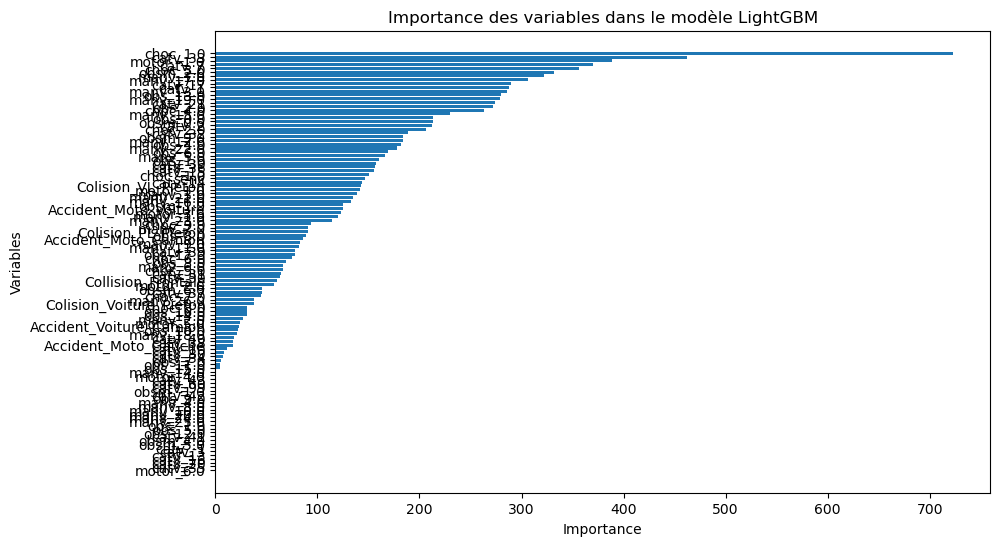

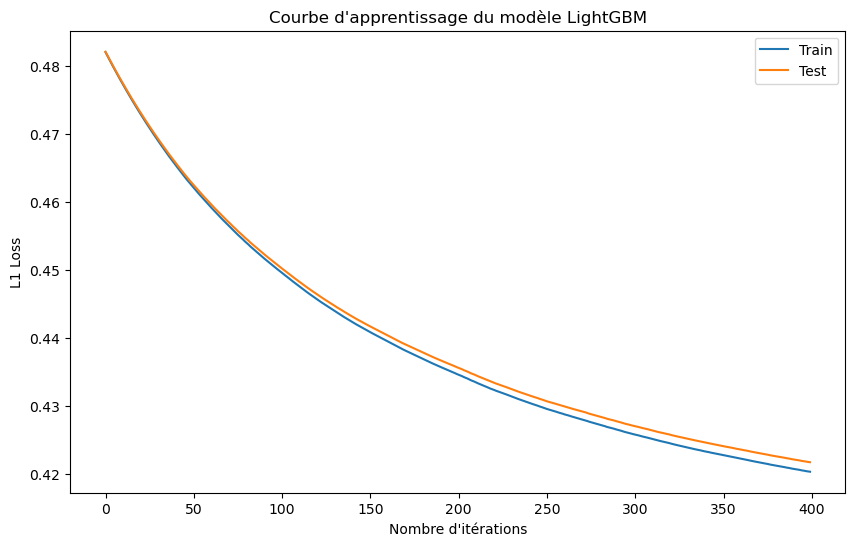

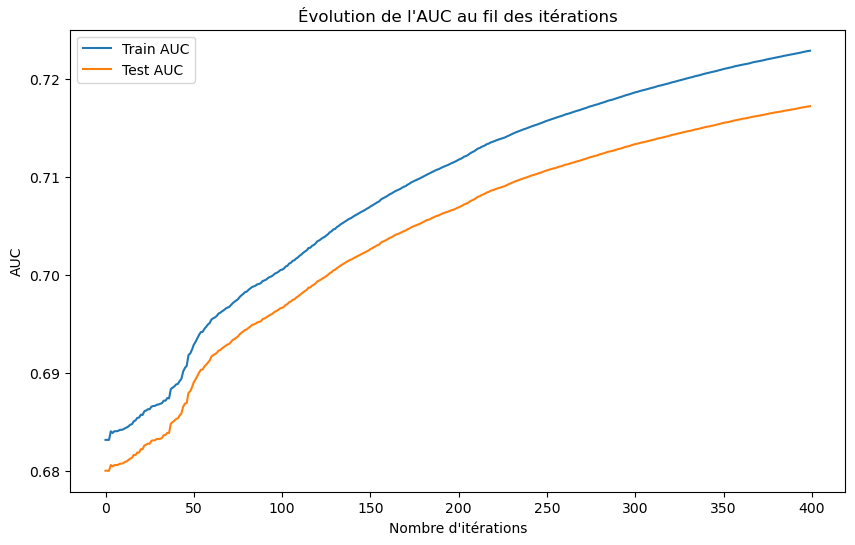

In [38]:
feature_imp_df = training_model(lgb_model,X,y)

In [39]:
vehicules_fe_clean = vehicule_fe.copy()

In [40]:
best_features = feature_imp_df[feature_imp_df['Importance'] > 100]

In [41]:
X = vehicules_fe_clean[best_features['Feature'].to_list()]
y = vehicules_fe_clean['GRAVE']

In [42]:
best_features.T

,95,79,104,67,97,58,10,26,73,64,22,50,28,75,39,98,24,37,56,65,96,78,62,21,41,31,43,14,38,76,82,71,94,0,70,7,105,12,30,25,57,1,107,9,32
Feature,choc_1.0,catv_33,motor_-1.0,catv_7,choc_3.0,obsm_2.0,manv_1.0,manv_17.0,catv_17,catv_1,manv_13.0,obs_13.0,manv_19.0,catv_21,obs_2.0,choc_4.0,manv_15.0,obs_0.0,obsm_0.0,catv_2,choc_2.0,catv_32,obsm_9.0,manv_12.0,obs_4.0,manv_22.0,obs_6.0,manv_5.0,obs_1.0,catv_30,catv_36,catv_15,choc_-1.0,senc,catv_14,Colision_VL_Pieton,motor_1.0,manv_3.0,manv_21.0,manv_16.0,obsm_1.0,Accident_Moto_Voiture,motor_3.0,manv_-1.0,manv_23.0
Importance,723,462,389,370,356,332,322,306,290,288,286,280,279,274,272,263,230,213,213,212,206,189,184,184,182,178,169,166,160,157,156,155,151,147,144,143,142,139,135,133,125,125,123,120,114


In [43]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,verbose = -1,objective='binary',learning_rate = 0.005,n_estimators = 800, num_leaves  = 25)

AUC LightGBM: 0.7127152183926417


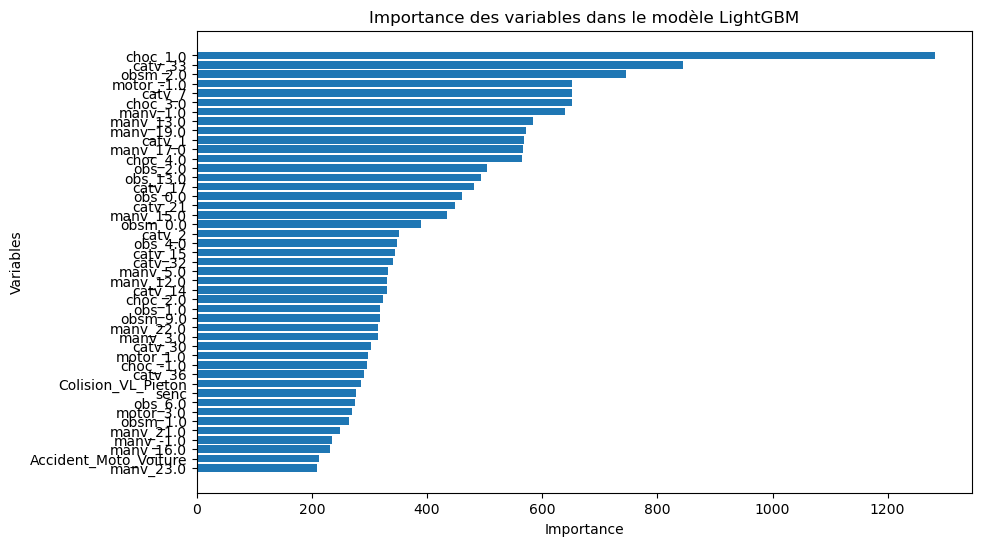

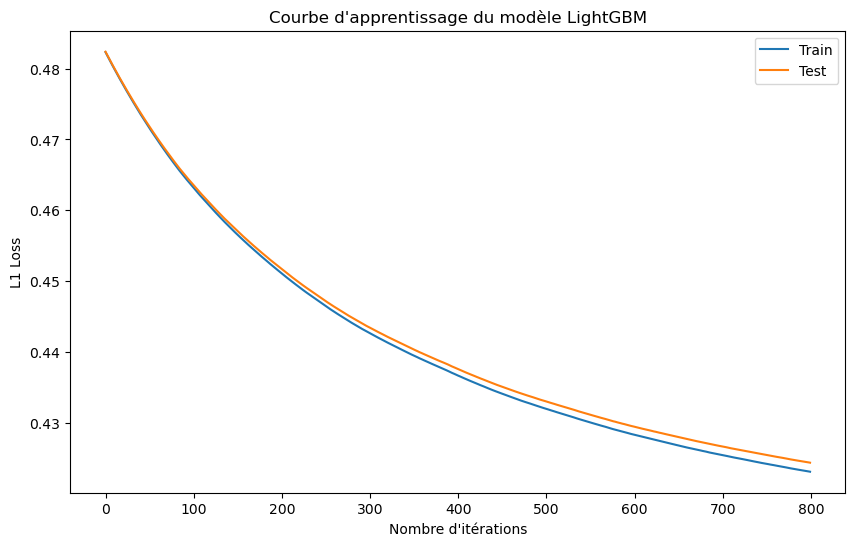

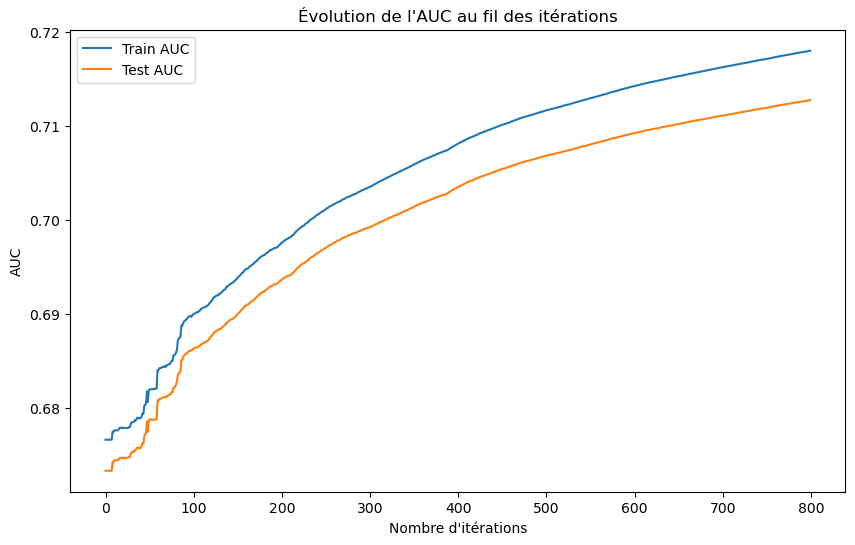

In [44]:
feature_imp_df_final = training_model(lgb_model,X,y)